The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
19 segments


100%|██████████| 1000/1000 [00:23<00:00, 42.69it/s]


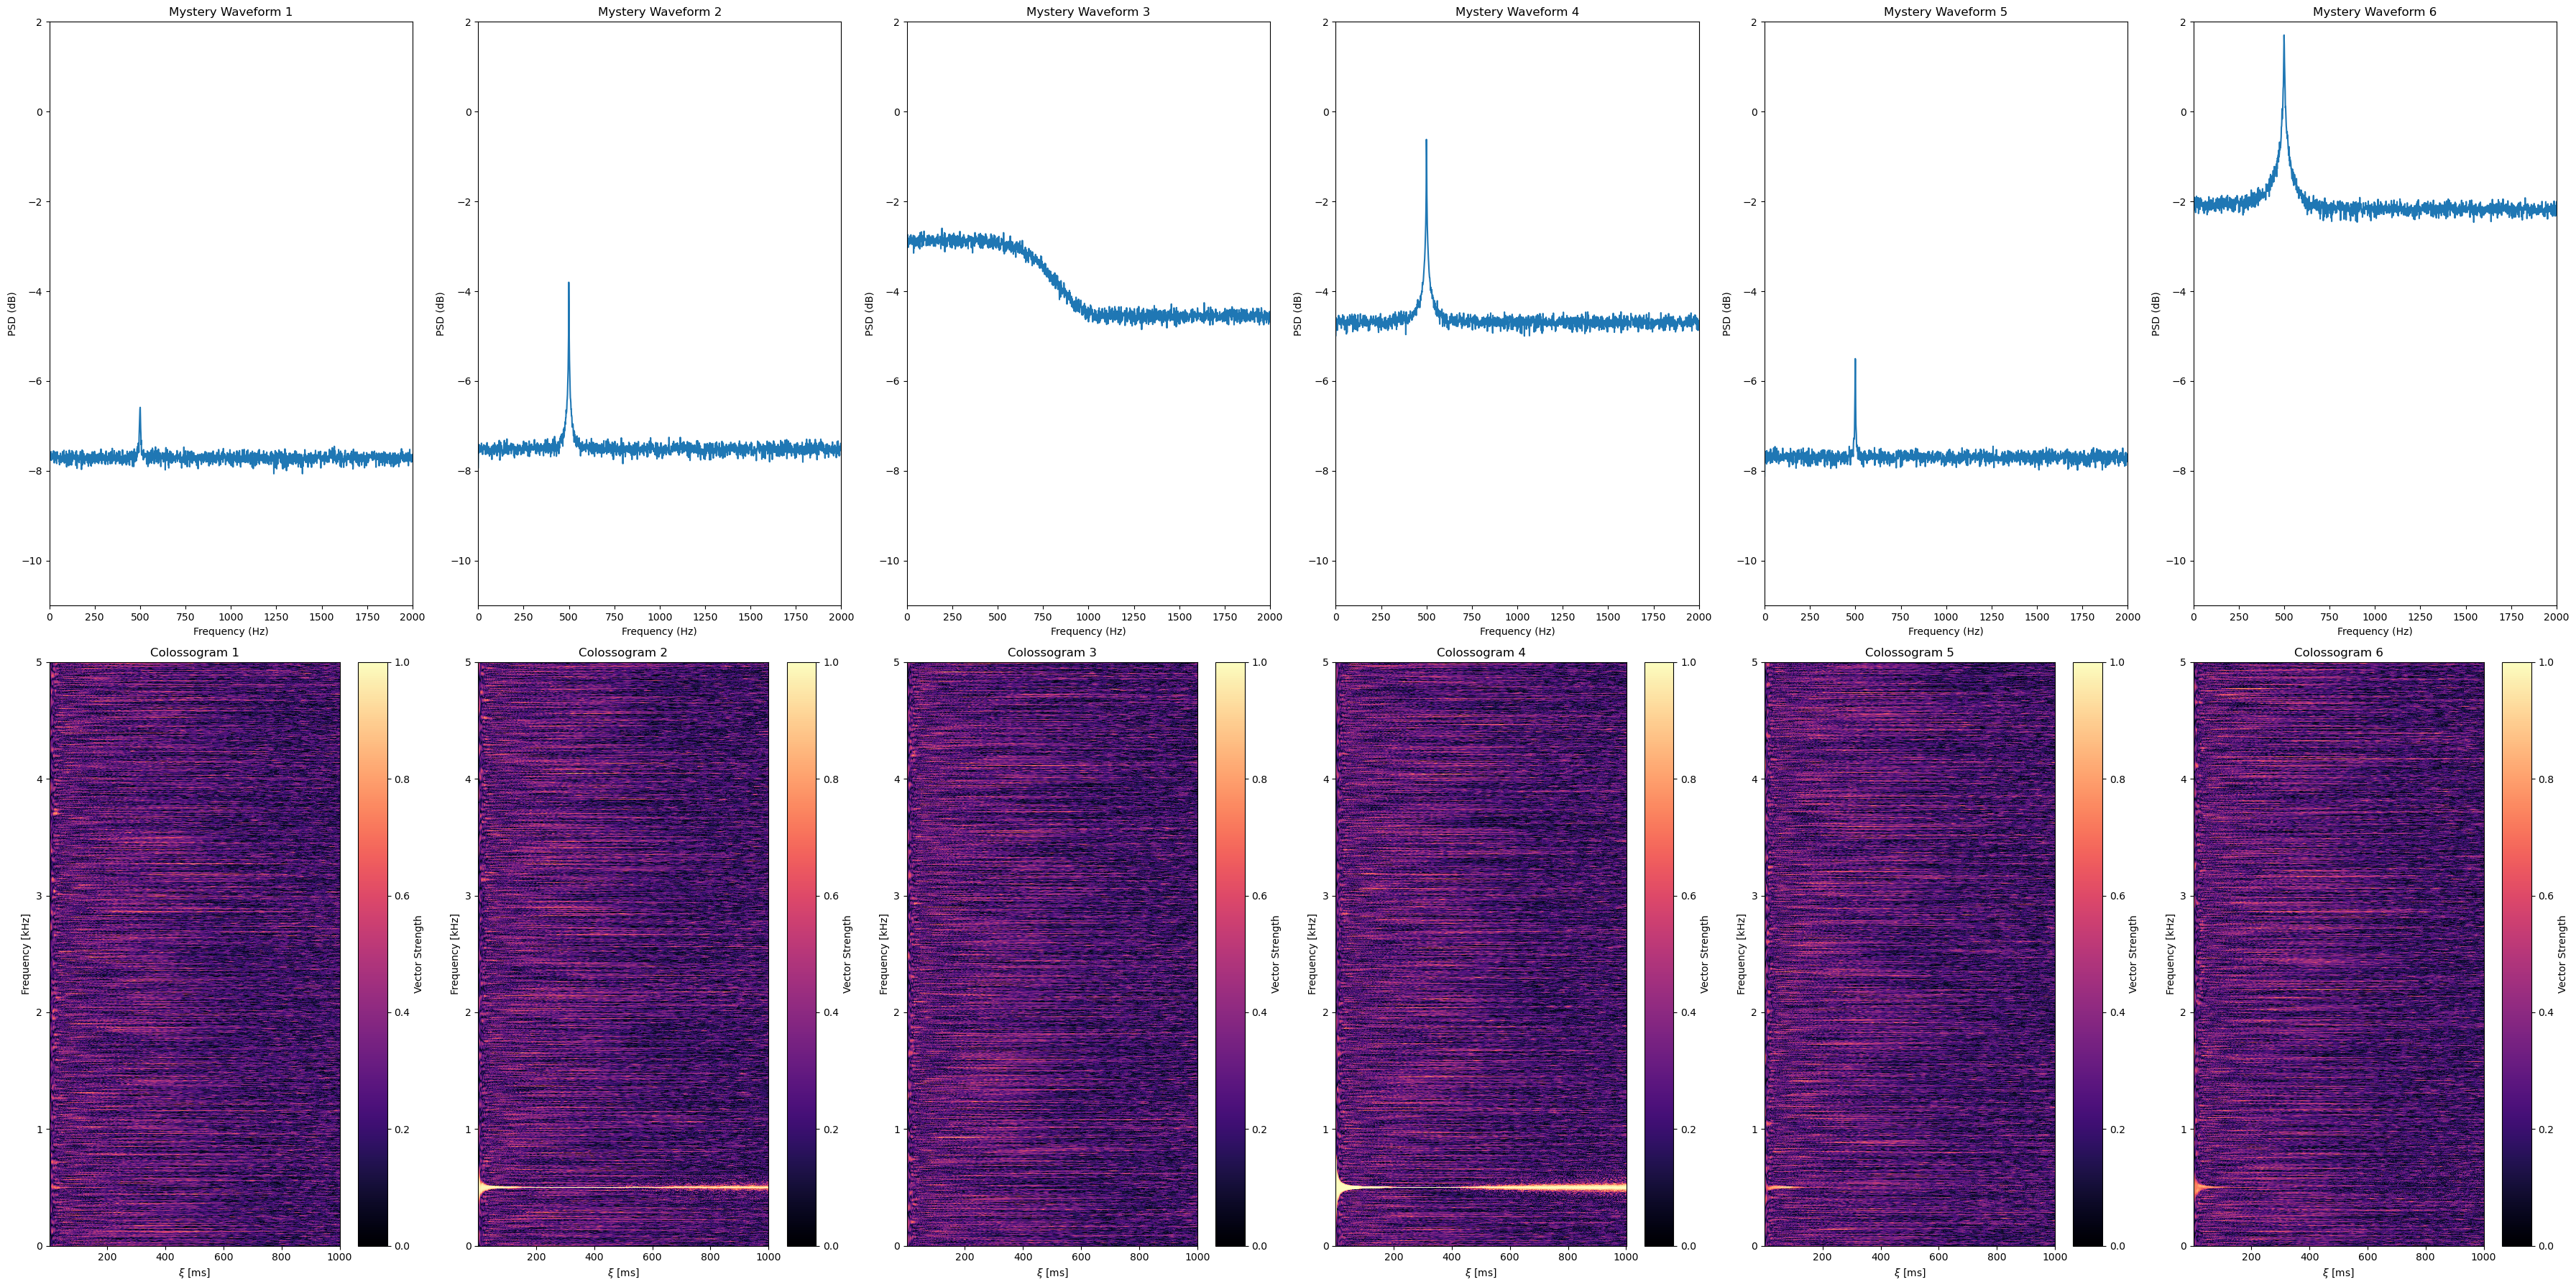

In [5]:
%load_ext autoreload
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import phaseco as pc
from tqdm import tqdm

wf = np.load(rf'.\\Mystery Data\\mystery1.wf1.npz')['arr_0']

# Parameters
fs=10000  # SR used when creating waveforms
tauS = 2**13
tau =  tauS/fs
delta_xi = 0.001
min_xi = delta_xi
max_xi = 0.2
rho = 1
noise_amp = 0.01

for max_xi in [1]:
    num_xis = int((max_xi - min_xi) / delta_xi) + 1
    xis = np.linspace(min_xi, max_xi, num_xis)
    max_xiS = max(xis) * fs
    N_segs = int((len(wf) - tauS) / max_xiS)  # Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
    print(f"{N_segs} segments") 

    # Calculate things
    coherenceses = np.empty(6, dtype=object)
    psds = np.empty(6, dtype=object)
    for i_wf in range(1, 7):    
        # Initialize
        fileL= rf'.\\Mystery Data\\mystery1.wf{i_wf}.npz'  # file name to load in
        wf = np.load(fileL)['arr_0'] # 20 second long waveform
        wf = wf + np.random.normal(0, noise_amp, len(wf))
        
        # Get PSD
        f, psd = pc.get_welch(wf=wf, fs=fs, tauS=tauS, win_type='boxcar', scaling='density')
        psds[i_wf-1] = psd
        
        # Get colossogram
        coherences = np.zeros((len(f), len(xis)))
        
        for i, xi in enumerate(tqdm(xis)):
            coherences[:, i] = pc.get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
            
        coherenceses[i_wf-1] = coherences
        

    # LOTS
    for orientation in ['LANDSCAPE']:
        plt.close('all')
        if orientation == 'PORTRAIT':
            plt.figure(figsize=(12, 36))
        elif orientation == 'LANDSCAPE':
            plt.figure(figsize=(36, 18))

        # Plot things
        for i_wf in range(1, 7):
            if orientation == 'PORTRAIT':
                plt.subplot(6, 2, i_wf*2 - 1)
            elif orientation == 'LANDSCAPE':
                plt.subplot(2, 6, i_wf)
            plt.plot(f, np.log10(psds[i_wf-1]), label='PSD')
            plt.xlim(0, 2000)
            plt.ylim(-11, 2)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('PSD (dB)')
            plt.title(f'Mystery Waveform {i_wf}')
            
            if orientation == 'PORTRAIT':
                plt.subplot(6, 2, i_wf*2)
            elif orientation == 'LANDSCAPE':
                plt.subplot(2, 6, i_wf + 6)
            pc.plot_colossogram(coherences=coherenceses[i_wf-1], f=f, xis=xis, tau=tau, title=f'Colossogram {i_wf}')

        plt.tight_layout()
        fig_folder = fr'Mystery Data\\Figures {orientation}\\'
        fig_fn = f'Waveform Challenge NOISE AMP = {noise_amp} - tau={tau:.3f}s, max_xi={max_xi:.3f}s, delta_xi={delta_xi:.3f}s, rho={rho}.png'
        plt.savefig(fig_folder + fig_fn, dpi=300)
        plt.show()
